In [1]:
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import pandas as pd
from scipy.stats import entropy
import math
import keras

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)

In [3]:
lpv = np.loadtxt('/home/saksham/Documents/starCSV/VarType1/1129039052854_VarType1.csv', delimiter=',', skiprows=1)
df = lpv[:,1]

In [9]:
df = pd.read_csv("./data/icici_04-18_clean.csv")
df = df['Close'][0:-1].values

In [4]:
train = df[0: int(math.floor(0.7 * len(df)))]
valid = df[int(math.floor(0.7 * len(df))):]

In [5]:
print(df.shape)

(546,)


In [6]:
print(train.shape, valid.shape)

(382,) (164,)


In [7]:
num_days = 7
x_train, y_train = [], []
for i in range(num_days,len(train)):
    x_train.append(train[i-num_days:i])
    y_train.append(train[i])
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
y_train.shape

(375,)

In [9]:
inputs = df[len(train) - num_days:]
x_test = []

for i in range(num_days,inputs.shape[0]):
    x_test.append(inputs[i-num_days:i])
x_test = np.array(x_test)
print(x_test.shape)

(164, 7)


In [10]:
x_train.shape

(375, 7)

In [11]:
def return_features(a):
    Feature_array = []
    for row in range(0,a.shape[0]):
        mean = np.mean(a[row])
        f = np.array([mean])
        skewness = skew(a[row], axis=0, bias=True)
        f = np.append(f, skewness)
        kurt = kurtosis(a[row], axis=0, fisher=True, bias=True)
        f= np.append(f, kurt)
        variance = np.var(a[row])
        f = np.append(f, variance)
        std = np.std(a[row])
        f = np.append(f, std)
        x = np.arange(0,len(a[row]),1)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,a[row])
        f = np.append(f, slope)
        f = np.append(f, entropy1(a[row]))
        df = pd.DataFrame({'A' : a[row]})
        f = np.append(f,df.ewm(alpha = 0.6).mean().iloc[-1,0])
        Feature_array.append(f)
    return Feature_array

Feature_array = return_features(x_train)
x_train = np.asarray(Feature_array)


Feature_array = return_features(x_test)
x_test = np.asarray(Feature_array)

In [12]:
# x_train = np.reshape(Feature_train, (Feature_train.shape[0],Feature_train.shape[1]))
# x_test = np.reshape(Feature_test, (Feature_test.shape[0],Feature_test.shape[1]))

model = keras.models.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu',input_dim=x_train.shape[1]))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(1))
model.summary()
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())
model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(x_test, valid) )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________
Train on 375 samples, validate on 164 samples
Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 32.4874 - val_los

In [13]:
closing_price = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((valid.ravel()-closing_price.ravel()),2)))
print(rms)

0.4228659006720695


# Train Accuracy and plot

In [43]:
# # Best Model
# # model.load_weights(filepath)
score = model.evaluate(x_test, valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

IndexError: invalid index to scalar variable.

In [45]:
import seaborn as sns
sns.set(font_scale = 1.8)

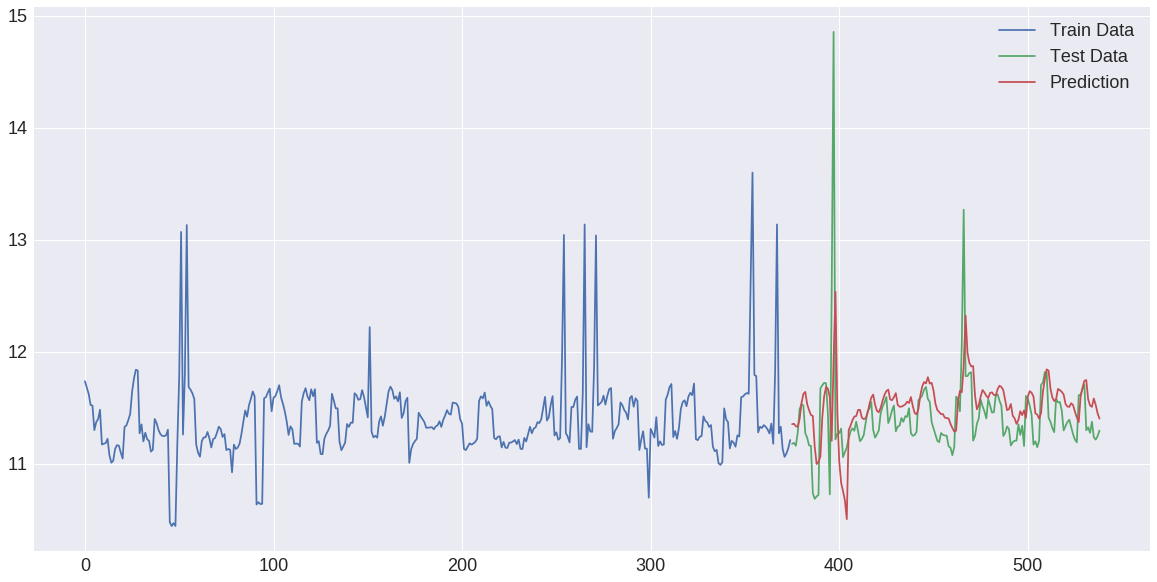

In [50]:
train = y_train
closing_price_x = np.arange(len(y_train), len(y_train) + len(closing_price), 1)
valid_x = np.arange(len(y_train), len(y_train) + len(valid), 1)
plt.figure(figsize=(20,10))
plt.plot(train, label = 'Train Data')
plt.plot(valid_x, valid, label = 'Test Data')
plt.plot(closing_price_x, closing_price, label = 'Prediction')
plt.legend()
plt.show()

In [51]:
valid.shape

(164,)

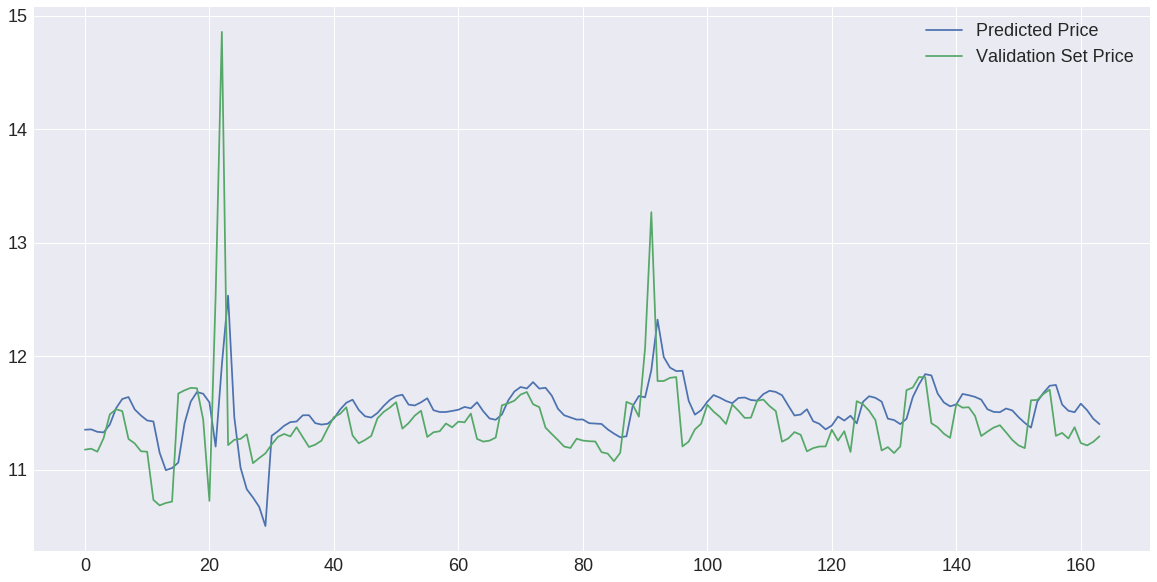

In [52]:
# y_pred = model.predict(x_train)
plt.figure(figsize=(20,10))
plt.plot(closing_price.ravel(), label = 'Predicted Price')
plt.plot(valid.ravel(), label = 'Validation Set Price')
plt.legend()